# 🧠 Sistema de Scoring Universal basado en las 5 C's del Crédito
Este notebook permite aplicar el sistema de scoring crediticio a cualquier base de datos.
Detecta automáticamente variables categóricas y numéricas, entrena un modelo, y genera puntuaciones por variable, categoría y las 5 C’s del crédito.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## 1️⃣ Lectura de Datos y Creación del Target

In [2]:
# Configuración de entrada
ruta = './../Registros_sin_nulos.csv'  # Cambia la ruta según corresponda
target_column = 'diasmora'
umbral_default = 7

# Cargar datos
df = pd.read_csv(ruta)

# Crear variable target
df['target'] = df[target_column].apply(lambda x: 1 if x > umbral_default else 0)

# Eliminar columnas irrelevantes
df = df.drop(columns=['nosocio', 'nocredito', 'sucursal', target_column], errors='ignore')

print('✅ Datos cargados:', df.shape)
df.head()

✅ Datos cargados: (14148, 30)


,clasificacion,producto,monto,tasaordinaria,tasamoratoria,plazocredito,frecuenciacapint,renovadoestructurado,vigentevencido,montogarantialiq,montogarantiapre,montogarantiahipo,escolaridad,codigo_postal,cod_actividad,antiguedad_actividad,ingresos_ordinarios,num_dependientes,reputaciÓn_localidad,antigudad_domicilio,exp_cred_externa,exp_cred_interna,cap_pago,tipo_casa,deudas,permiso_para_funcionar,comercio_en_region,empleo,permiso_negocio,target
0,CONSUMO,CREDI-PROMOCION LACHAO,15000.0,30.0,60.0,12 MESES,30,NORMAL,VIGENTE,750.0,0.0,0.0,SABE LEER Y ESCRIBIR,71940.0,8719017.0,MAYOR DE 5 AÑOS,6000.0,0.0,MUY BUENA,MAYOR DE 5 AÑOS,MOP 1,PAGO PUNTUAL(CALIF. A),MARGEN DEL 30% SOBRE SALDO DISPONIBLE NETO,EL SOCIO CUENTA CON CASA FAMILIAR,SIN DEUDAS,NO,SI,EMPLEO PERMANENTE,NO,0
1,CONSUMO,CREDI-CONSUMO LACHAO CONFIANZA,20000.0,30.0,60.0,18 MESES,30,NORMAL,VIGENTE,2000.0,0.0,0.0,SABE LEER Y ESCRIBIR,71940.0,8719017.0,MAYOR DE 5 AÑOS,6000.0,0.0,MUY BUENA,MAYOR DE 5 AÑOS,MOP 1,PAGO PUNTUAL(CALIF. A),MARGEN DEL 30% SOBRE SALDO DISPONIBLE NETO,EL SOCIO CUENTA CON CASA FAMILIAR,SIN DEUDAS,NO,SI,EMPLEO PERMANENTE,NO,0
2,CONSUMO,CREDI-CONSUMO LACHAO CONFIANZA,10000.0,30.0,60.0,12 MESES,30,NORMAL,VIGENTE,1000.0,0.0,0.0,PREPARATORIA,71940.0,9411998.0,DE 1 A 3 AÑOS,14800.0,2.0,MUY BUENA,MAYOR DE 5 AÑOS,MOP 1,HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B),MARGEN DEL 30% SOBRE SALDO DISPONIBLE NETO,EL SOCIO CUENTA CON CASA FAMILIAR,DEUDAS DEL 1% AL 20% DEL PATRIMONIO,NO,SI,EMPLEO PERMANENTE,NO,0
3,CONSUMO,CREDI-CONSUMO LACHAO CONFIANZA,10000.0,30.0,60.0,12 MESES,30,NORMAL,VIGENTE,1000.0,0.0,0.0,PREPARATORIA,71940.0,9411998.0,DE 1 A 3 AÑOS,14800.0,2.0,MUY BUENA,MAYOR DE 5 AÑOS,MOP 1,HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B),MARGEN DEL 30% SOBRE SALDO DISPONIBLE NETO,EL SOCIO CUENTA CON CASA FAMILIAR,DEUDAS DEL 1% AL 20% DEL PATRIMONIO,NO,SI,EMPLEO PERMANENTE,NO,0
4,CONSUMO,CREDI-CONSUMO LACHAO CONFIANZA,5000.0,30.0,60.0,12 MESES,30,NORMAL,VIGENTE,500.0,0.0,0.0,PREPARATORIA,71940.0,9411998.0,DE 1 A 3 AÑOS,14800.0,2.0,MUY BUENA,MAYOR DE 5 AÑOS,MOP 1,HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B),MARGEN DEL 30% SOBRE SALDO DISPONIBLE NETO,EL SOCIO CUENTA CON CASA FAMILIAR,DEUDAS DEL 1% AL 20% DEL PATRIMONIO,NO,SI,EMPLEO PERMANENTE,NO,0


## 2️⃣ Definición de las 5 C’s del Crédito

In [3]:
C5 = {
    'Carácter': ['reputación_localidad', 'exp_cred_externa', 'exp_cred_interna', 'renovadoestructurado'],
    'Capacidad': ['ingresos_ordinarios', 'num_dependientes', 'cap_pago', 'empleo'],
    'Capital': ['monto', 'tasaordinaria', 'tasamoratoria', 'deudas'],
    'Condiciones': ['producto', 'clasificacion', 'comercio_en_region', 'permiso_para_funcionar', 'plazocredito', 'frecuenciacapint'],
    'Colateral': ['montogarantialiq', 'montogarantiapre', 'montogarantiahipo']
}

# Filtrar solo las variables existentes
C5 = {k: [v for v in vars_ if v in df.columns] for k, vars_ in C5.items()}
C5

{'Carácter': ['exp_cred_externa', 'exp_cred_interna', 'renovadoestructurado'],
 'Capacidad': ['ingresos_ordinarios',
  'num_dependientes',
  'cap_pago',
  'empleo'],
 'Capital': ['monto', 'tasaordinaria', 'tasamoratoria', 'deudas'],
 'Condiciones': ['producto',
  'clasificacion',
  'comercio_en_region',
  'permiso_para_funcionar',
  'plazocredito',
  'frecuenciacapint'],
 'Colateral': ['montogarantialiq', 'montogarantiapre', 'montogarantiahipo']}

## 3️⃣ Codificación y Escalamiento

In [4]:
# Detectar tipos de variables
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(exclude=['object']).drop(columns=['target'], errors='ignore').columns.tolist()

X = df.drop(columns=['target'])
y = df['target']

# Codificar categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Escalar numéricas
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('✅ Datos codificados y escalados correctamente.')

✅ Datos codificados y escalados correctamente.


## 4️⃣ Entrenamiento del Modelo

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
joblib.dump(model, 'credit_scoring_model.pkl')
print('✅ Modelo entrenado correctamente.')

✅ Modelo entrenado correctamente.


## 5️⃣ Cálculo de Importancia y Scoring por 5C’s

In [9]:
importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model.feature_importances_
}).sort_values('Importancia', ascending=False)

def categoria_5C(var):
    for c, vars_ in C5.items():
        if var in vars_:
            return c
    return 'Otras'

importances['Categoria_5C'] = importances['Variable'].apply(categoria_5C)
importances.head(10)
importances.to_csv("importancia_feature_category.csv", index=False)

## 6️⃣ Visualización de Scores Promedio por Categoría (Radar Chart)

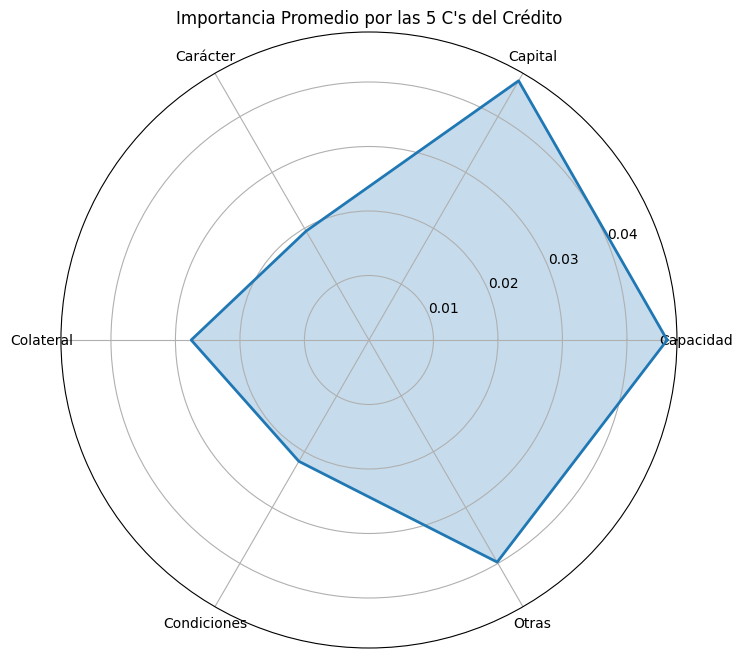

In [7]:
scores_5c = importances.groupby('Categoria_5C')['Importancia'].mean().to_dict()

categories = list(scores_5c.keys())
values = list(scores_5c.values())
categories += categories[:1]
values += values[:1]

angles = [n / float(len(categories)-1) * 2 * np.pi for n in range(len(categories))]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories[:-1])
plt.title('Importancia Promedio por las 5 C\'s del Crédito')
plt.show()

## 7️⃣ Guardar Resultados

In [8]:
importances.to_csv('pesos_variables_5C.csv', index=False)
print('📁 Archivo guardado: pesos_variables_5C.csv')

📁 Archivo guardado: pesos_variables_5C.csv
